# 3.topic_models






Here we implement the hSBM and LDA topic models used to detect the bushfire topic in our set of tweets. We also generate an initial list keywords based on the topics and plot the distribution of the bushfire topic accross documents and parties. 

In [1]:
#Graph tool package
from topsbm import TopSBM
import graph_tool.all as gt

#Necessary packages
import scipy.stats as stats
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime 
import logging 
import sys 
import requests
import io

#Importing packages for data visualization 
import matplotlib.pyplot as plt

#Importing packages for LDA
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore

## Preprocessing

We begin by defining the document-term-matrix in which we remove infrequent words.

In [2]:
#Read the twitter data
path = "data/final_df.csv"
df = pd.read_csv(path, index_col = 0)

#Subset bushfire period
df = df.loc[(df["created_at"] >= "2019-06-01") & (df["created_at"] <= "2020-06-01")] 
df = df.dropna(subset=["final_text"])

#Create dfm. Remove infrequent words to reduce dimensionality
vect = CountVectorizer(min_df = 10)
X = vect.fit_transform(df["final_text"])

X.shape

(50081, 10970)

## Modeling

Next we fit both the hSBM and LDA model.The parameter for the amount of topics in LDA is set based on the hSBM results.

### **hSBM**

In [3]:
#Create instance of the sbmtm-class
model = TopSBM(random_state = 32)
#Fit model to dfm
Xt = model.fit_transform(X)

/home/matiasp/.local/lib/python3.8/site-packages/topsbm/transformer.py:279: RuntimeWarning: invalid value encountered in true_divide
  p_td_d = (n_db / np.sum(n_db, axis=1)[:, np.newaxis]).T
/home/matiasp/.local/lib/python3.8/site-packages/topsbm/transformer.py:285: RuntimeWarning: invalid value encountered in true_divide
  p_tw_d = (n_dbw / np.sum(n_dbw, axis=1)[:, np.newaxis]).T


In [4]:
#Check amount of l1 topics
model.groups_[1]['p_w_tw'].shape

(10970, 230)

In [5]:
#Check amount of l2 topics
model.groups_[2]['p_w_tw'].shape

(10970, 42)

In [6]:
#Create a dataframe of topics and loadings corresponding to each word
hsb_topics = pd.DataFrame(model.groups_[2]['p_w_tw'],index=vect.get_feature_names())#.transpose()

We find topic 17 in the second hierarchy to be useful and contain relevant keywords for the bushfire. Also topic 1 seems to capture a climate topic.

In [7]:
#Print the most 10 most important words for each topic
for topic in hsb_topics.columns:
    if topic in [1, 17]:
        print(hsb_topics[topic].nlargest(10))
        print("-"*66)

chang           0.085036
climat          0.083333
action          0.044675
polici          0.042972
climat_chang    0.042461
emiss           0.026624
green           0.026396
energi          0.023955
global          0.023955
coal            0.020777
Name: 1, dtype: float64
------------------------------------------------------------------
bushfir     0.096607
fire        0.068879
emerg       0.043716
impact      0.039398
affect      0.038724
area        0.030763
recoveri    0.029886
recent      0.022465
base        0.018822
devast      0.018552
Name: 17, dtype: float64
------------------------------------------------------------------


### LDA

In [8]:
#Create the corpus object based on the document-term-matrix
corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)
#Set parameter for topics based on hSBM
k = hsb_topics.shape[1]
#Running the LDA with K topics
lda_model = LdaMulticore(corpus=corpus, num_topics=k, passes = 100, iterations = 1000)
#Disabling logging
logging.disable(sys.maxsize)

In [ ]:
#Create a dataframe of topics and loadings corresponding to each word
lda_topics = pd.DataFrame(lda_model.get_topics(), columns = list(vect.get_feature_names())).transpose()
#Print the most 10 most important words for each topic
for col in lda_topics.columns:
    if col in [35, 38, 39]:
        print("-"*66)
        print(lda_topics[col].nlargest(10))

## Plotting distribution of topic across documents

Here we generate the plots in section 7.x that display the proportion of the bushfire topic across all documents, aggregated on party and weekly average. 

In [10]:
#Insert the corpus of documents in bag of word format and get a list of (topic, probability) per document. 
document_topics = list(lda_model.get_document_topics(corpus)) 

#Creating a list of names for all topics
lda_topics_names = ['topic_{}'.format(t) for t in range(k)]

#Creating a dataframe with topic distribution accross documents from LDA
lda_topic_dist = pd.DataFrame(np.zeros((len(document_topics),k)), columns = lda_topics_names)

#set column name
for i, doc in enumerate(document_topics): 
    for pair in doc: 
        lda_topic_dist.loc[i,'topic_{}'.format(pair[0])] = pair[1]

In [13]:
titles = df["party"]
#Create dataframe for document topic distribution from hSBM. Rename bushfire topic columns.
topic_dist = pd.DataFrame(model.groups_[2]['p_tw_d'], 
                          columns=titles).transpose().reset_index().rename(columns={"index":"party",
                                                                                    1:"hsb_climate",
                                                                                    17:"hsb_bushfire"})

#Add necessary columns from the original data frame
topic_dist["created_at"] = df["created_at"].tolist()
topic_dist["user_id"] = df["user_id"].tolist()
topic_dist['created_at'] = pd.to_datetime(topic_dist['created_at'], format = '%Y-%m-%d')

#Add columns for the bushfire topic found by LDA
topic_dist["lda_bushfire1"], topic_dist["lda_bushfire2"], topic_dist["lda_bushfire3"] = lda_topic_dist["topic_35"], lda_topic_dist["topic_38"], lda_topic_dist["topic_39"]

#Create a combined topic based on the two LDA topics
topic_dist["lda_bushfire_combined"] = topic_dist["lda_bushfire1"] + topic_dist["lda_bushfire2"] + topic_dist["lda_bushfire3"]

In [14]:
topic_dist['created_at'] = pd.to_datetime(topic_dist['created_at'], format = '%Y-%m-%d')

#Aggregate the data by week and get the mean value of bushfire proportion
topic_week = topic_dist.groupby("party").resample('W-Mon', 
                                                  on='created_at').agg({"party":"first", "created_at":"first",
                                                                        "hsb_climate":"mean",
                                                                        "hsb_bushfire":"mean",
                                                                        "lda_bushfire1":"mean", 
                                                                        "lda_bushfire2":"mean",
                                                                        "lda_bushfire3":"mean",
                                                                        "lda_bushfire_combined":"mean"}).reset_index(drop = True)

In [15]:
#Define the plot for 
def plot_topic(df, outcome, fig_name = None):
    with plt.style.context(['science']):
        
        parties = ["Liberal Party of Australia", "Australian Greens", "Australian Labor Party", 
                   "Centre Alliance", "The Nationals", "Liberal National Party of Queensland"]
        
        #define colors and markers
        colors_markers = [("#2c9deb", "o"), ("#2ceb3a", "^"), ("#f04222", "*"), 
                          ("#c008af", "D"), ("#FFC300", "v"), ("#ffb8d0", "s")]

        fig, ax = plt.subplots(figsize=(18, 8), dpi=600)
        for colmark, party in zip(colors_markers, parties):
            temp = df.loc[df["party"] == party]
            ax.plot(temp["created_at"], temp[outcome], color = colmark[0], marker = colmark[1], 
                    label = party, markersize = 10, alpha = 0.8)

        ax.set_ylabel("Bushfire Topic Proportion", size = 15)
        ax.set_xlabel("Date", size = 15)
        ax.legend()
        if fig_name:
            plt.savefig(fig_name)
        plt.show()

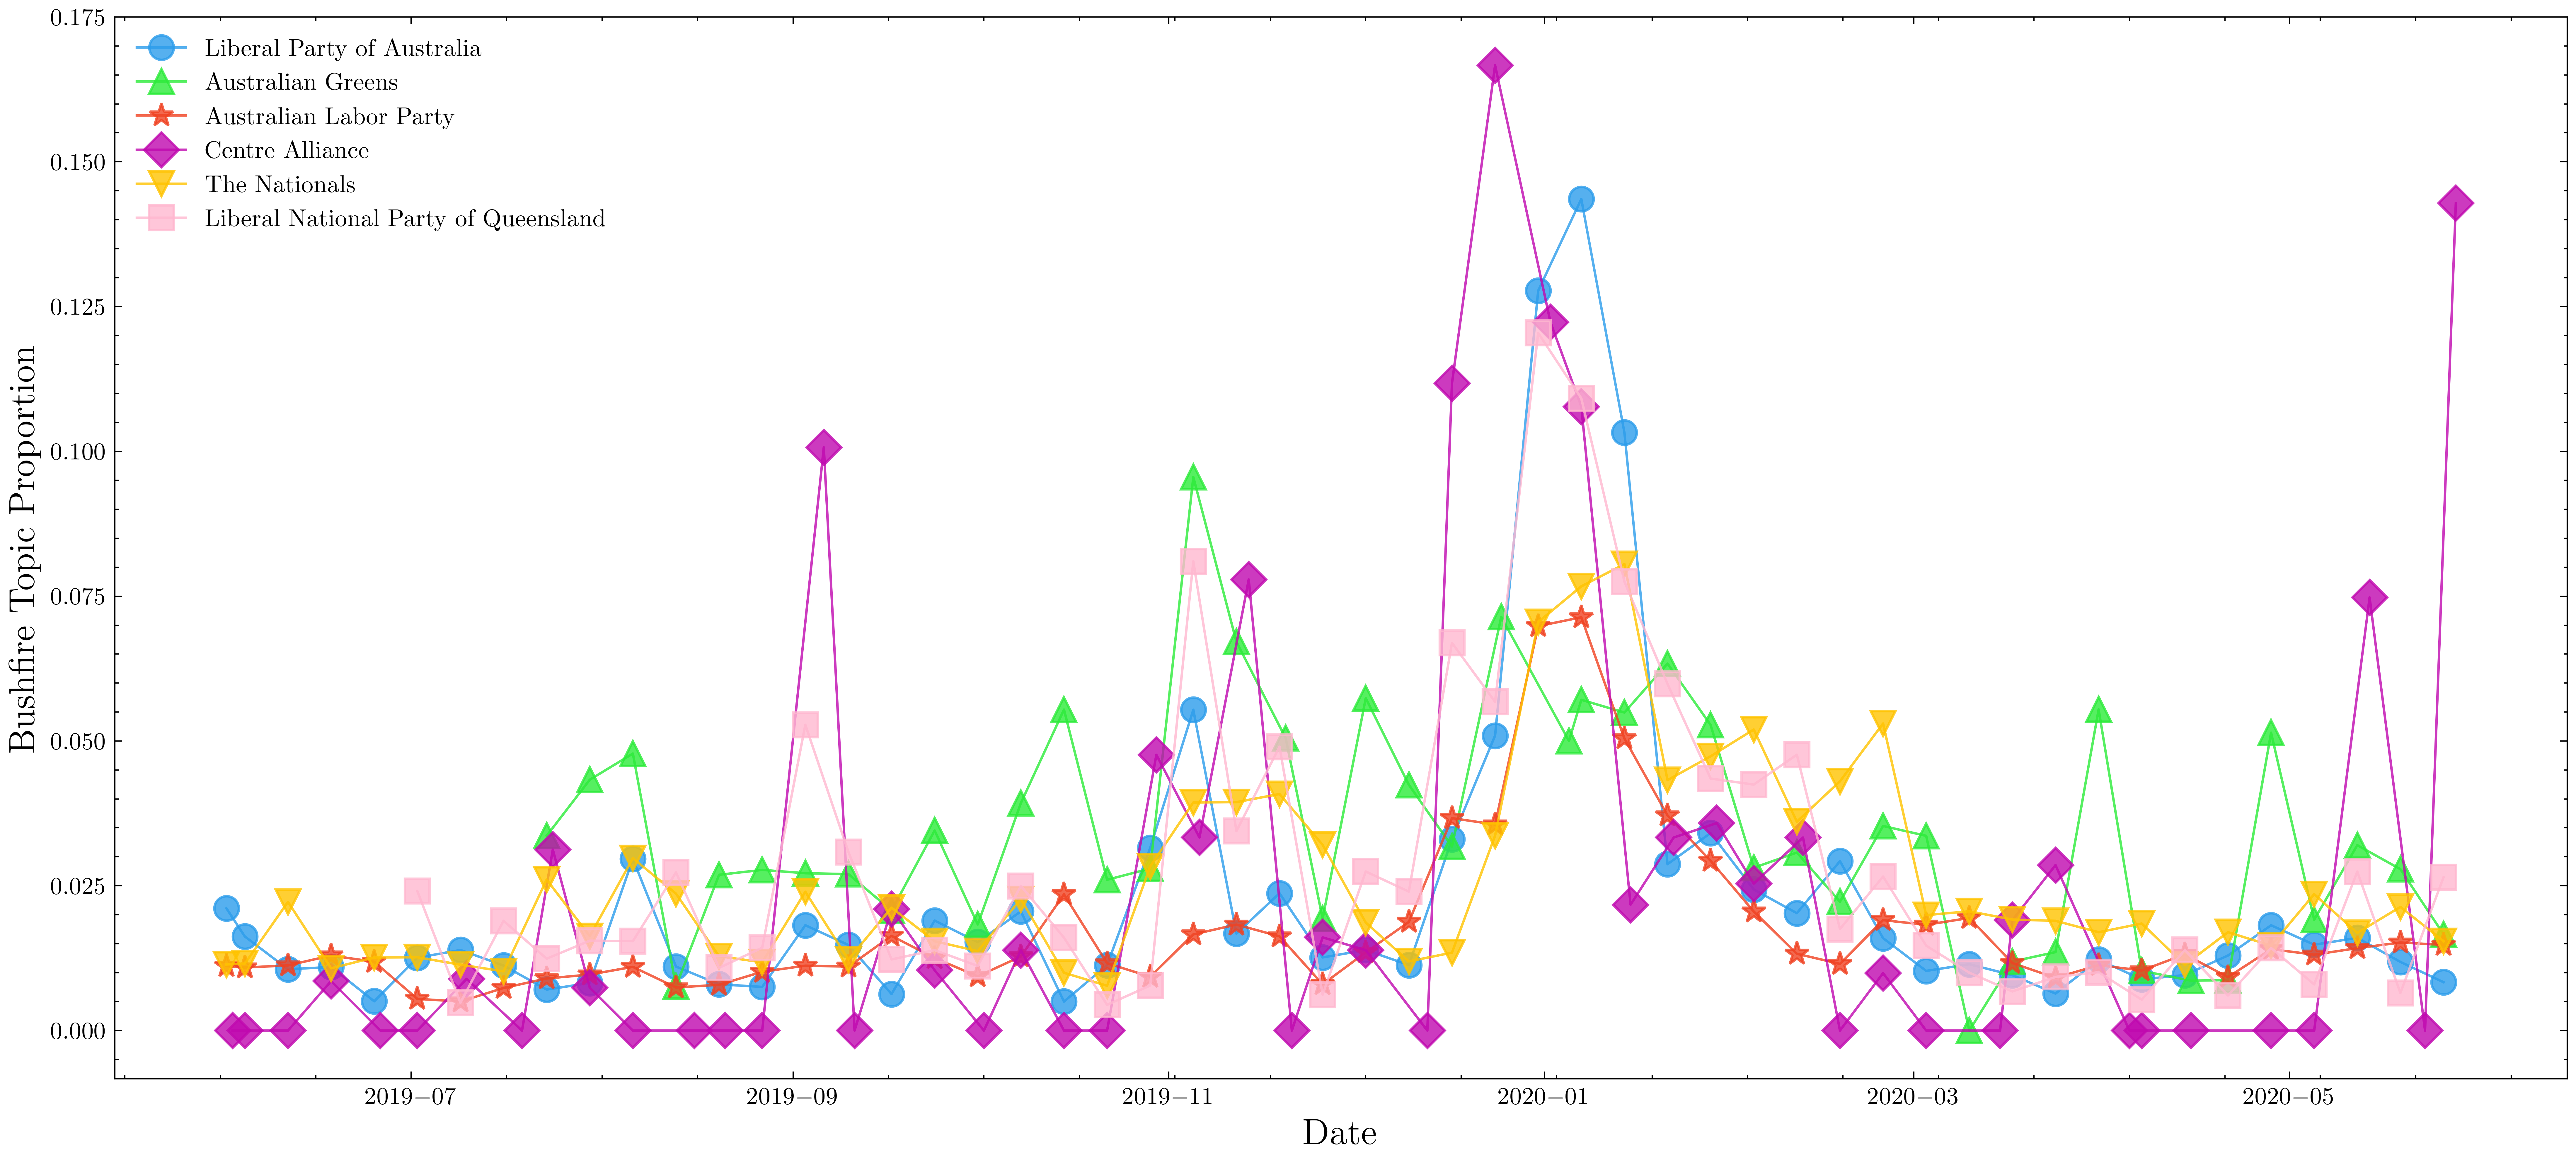

In [16]:
plot_topic(topic_week, "hsb_bushfire", "hsb_climate_plot.pdf")

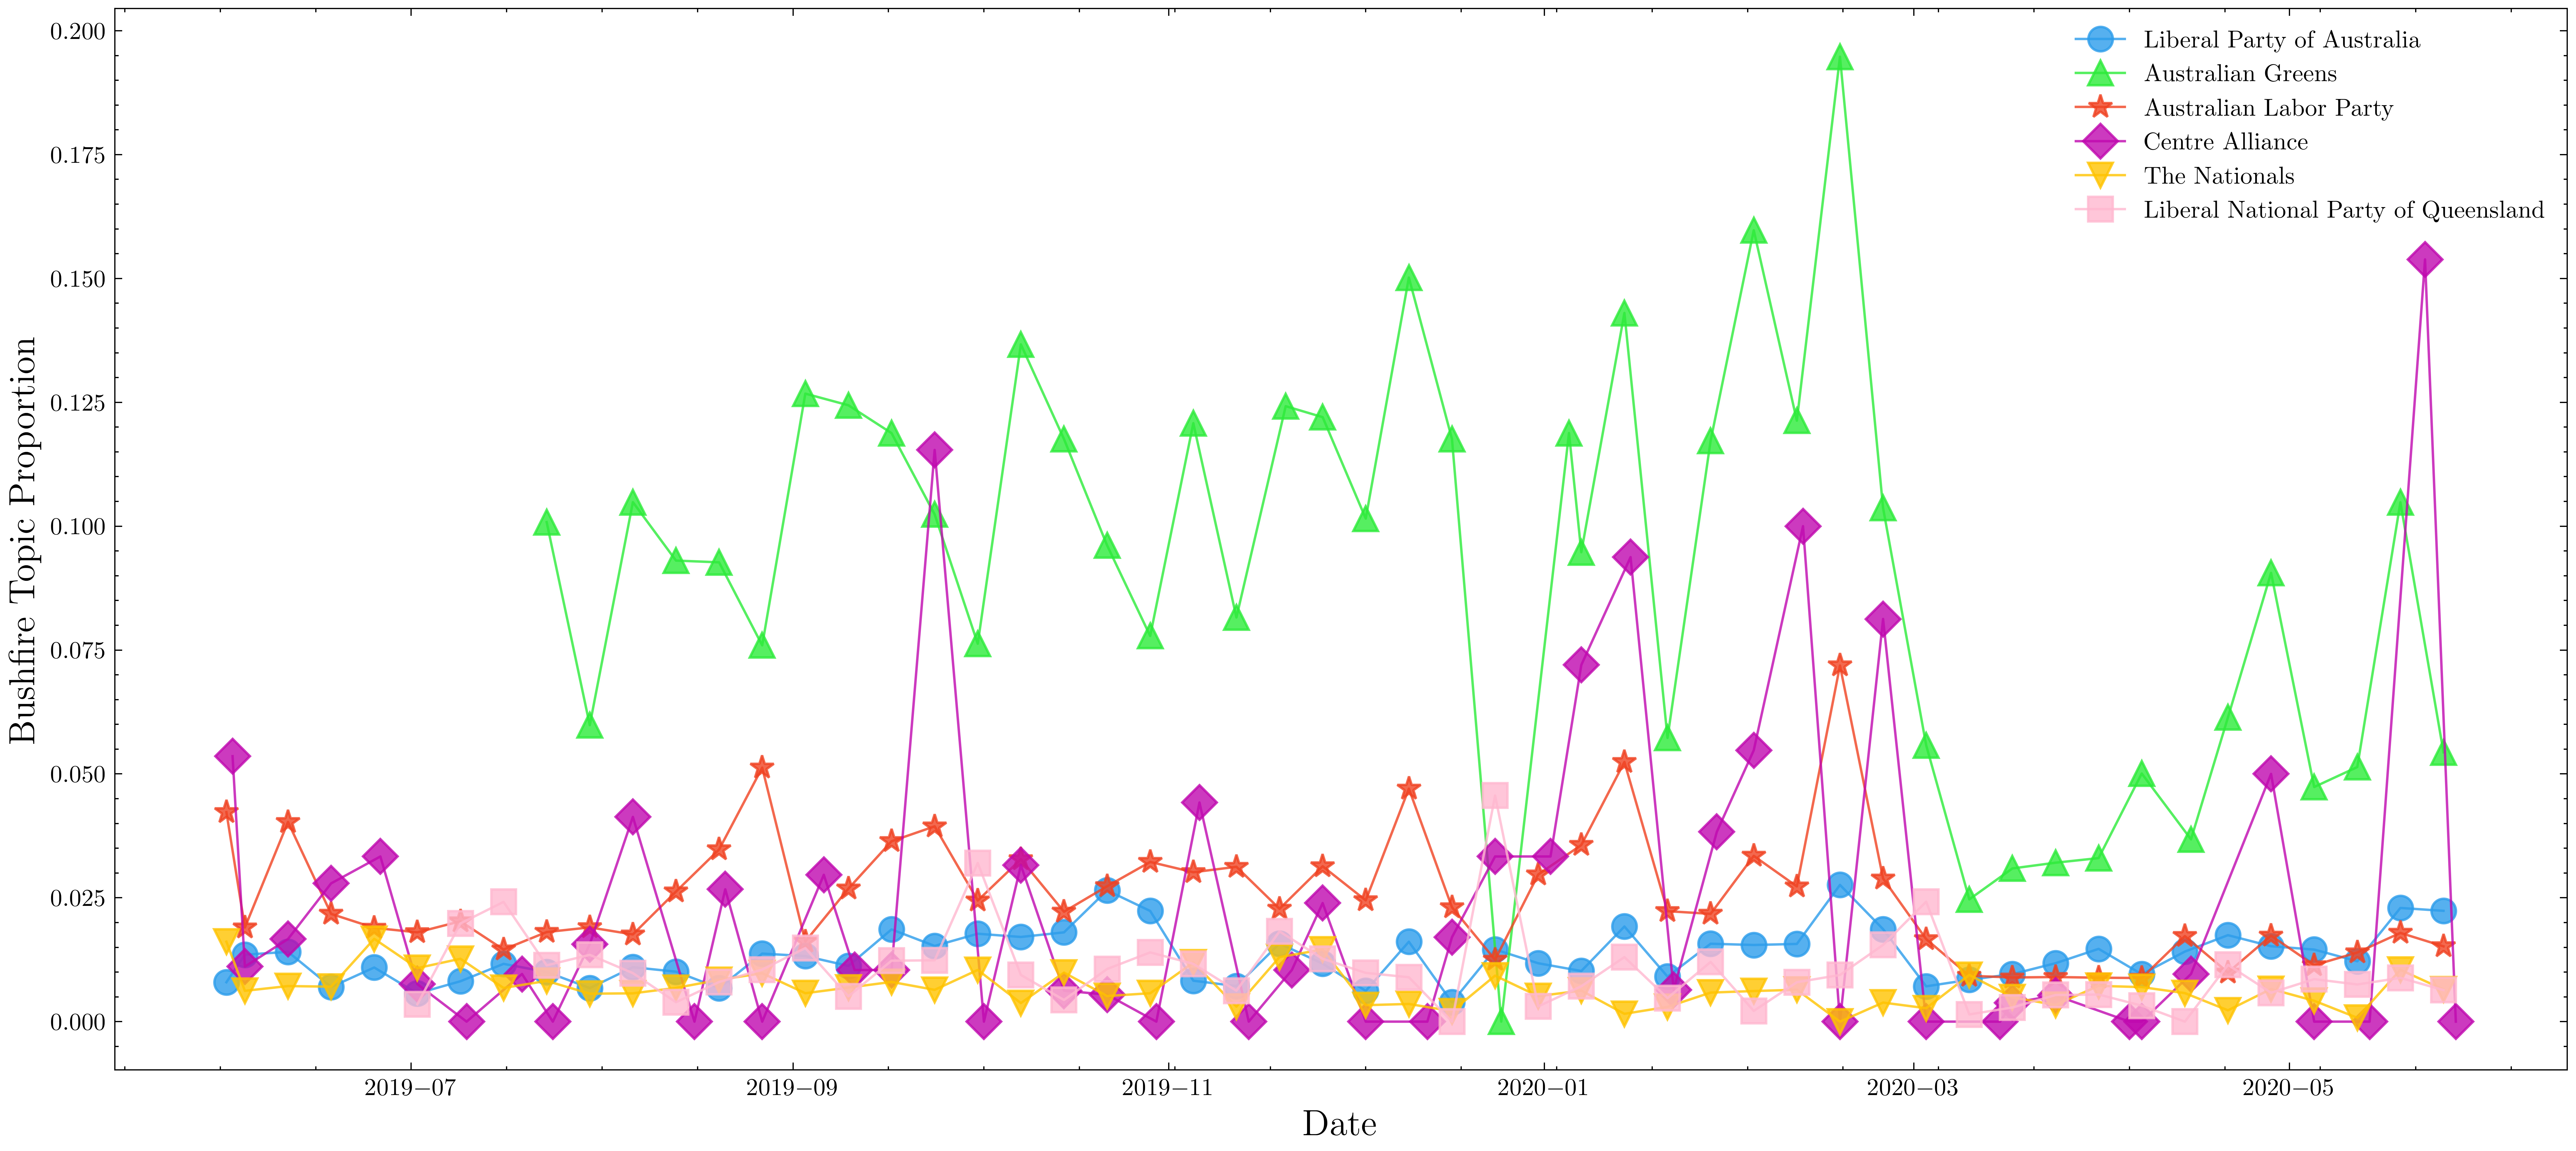

In [17]:
plot_topic(topic_week, "hsb_climate", "hsb_climate_plot.pdf")

## Correlation between hSBM and subset based on Keyword query

Lastly we evaluate the correlation between the hSB model and our bushfire subset defined in notebook *4.keyword_subsetting*.

In [19]:
data = pd.read_csv("data/final_df.csv", index_col=0)

In [20]:
#Calculate the proportion of the bushfire topic by taking mean of dummy
data = data.groupby(["party", "created_at"]).mean().reset_index()[["party", "bushfire_dummy", "created_at"]]

data["created_at"] = pd.to_datetime(data["created_at"])
data = data.loc[(data["created_at"] >= "2019-06-01") & 
                (data["created_at"] < "2020-06-01")].reset_index(drop = True)

#Aggregate data on week and correct period as before
data = data.groupby("party").resample('W-Mon', 
                                      on='created_at').agg({"party":"first", "created_at":"first",
                                                            "bushfire_dummy":"mean"}).reset_index(drop = True)

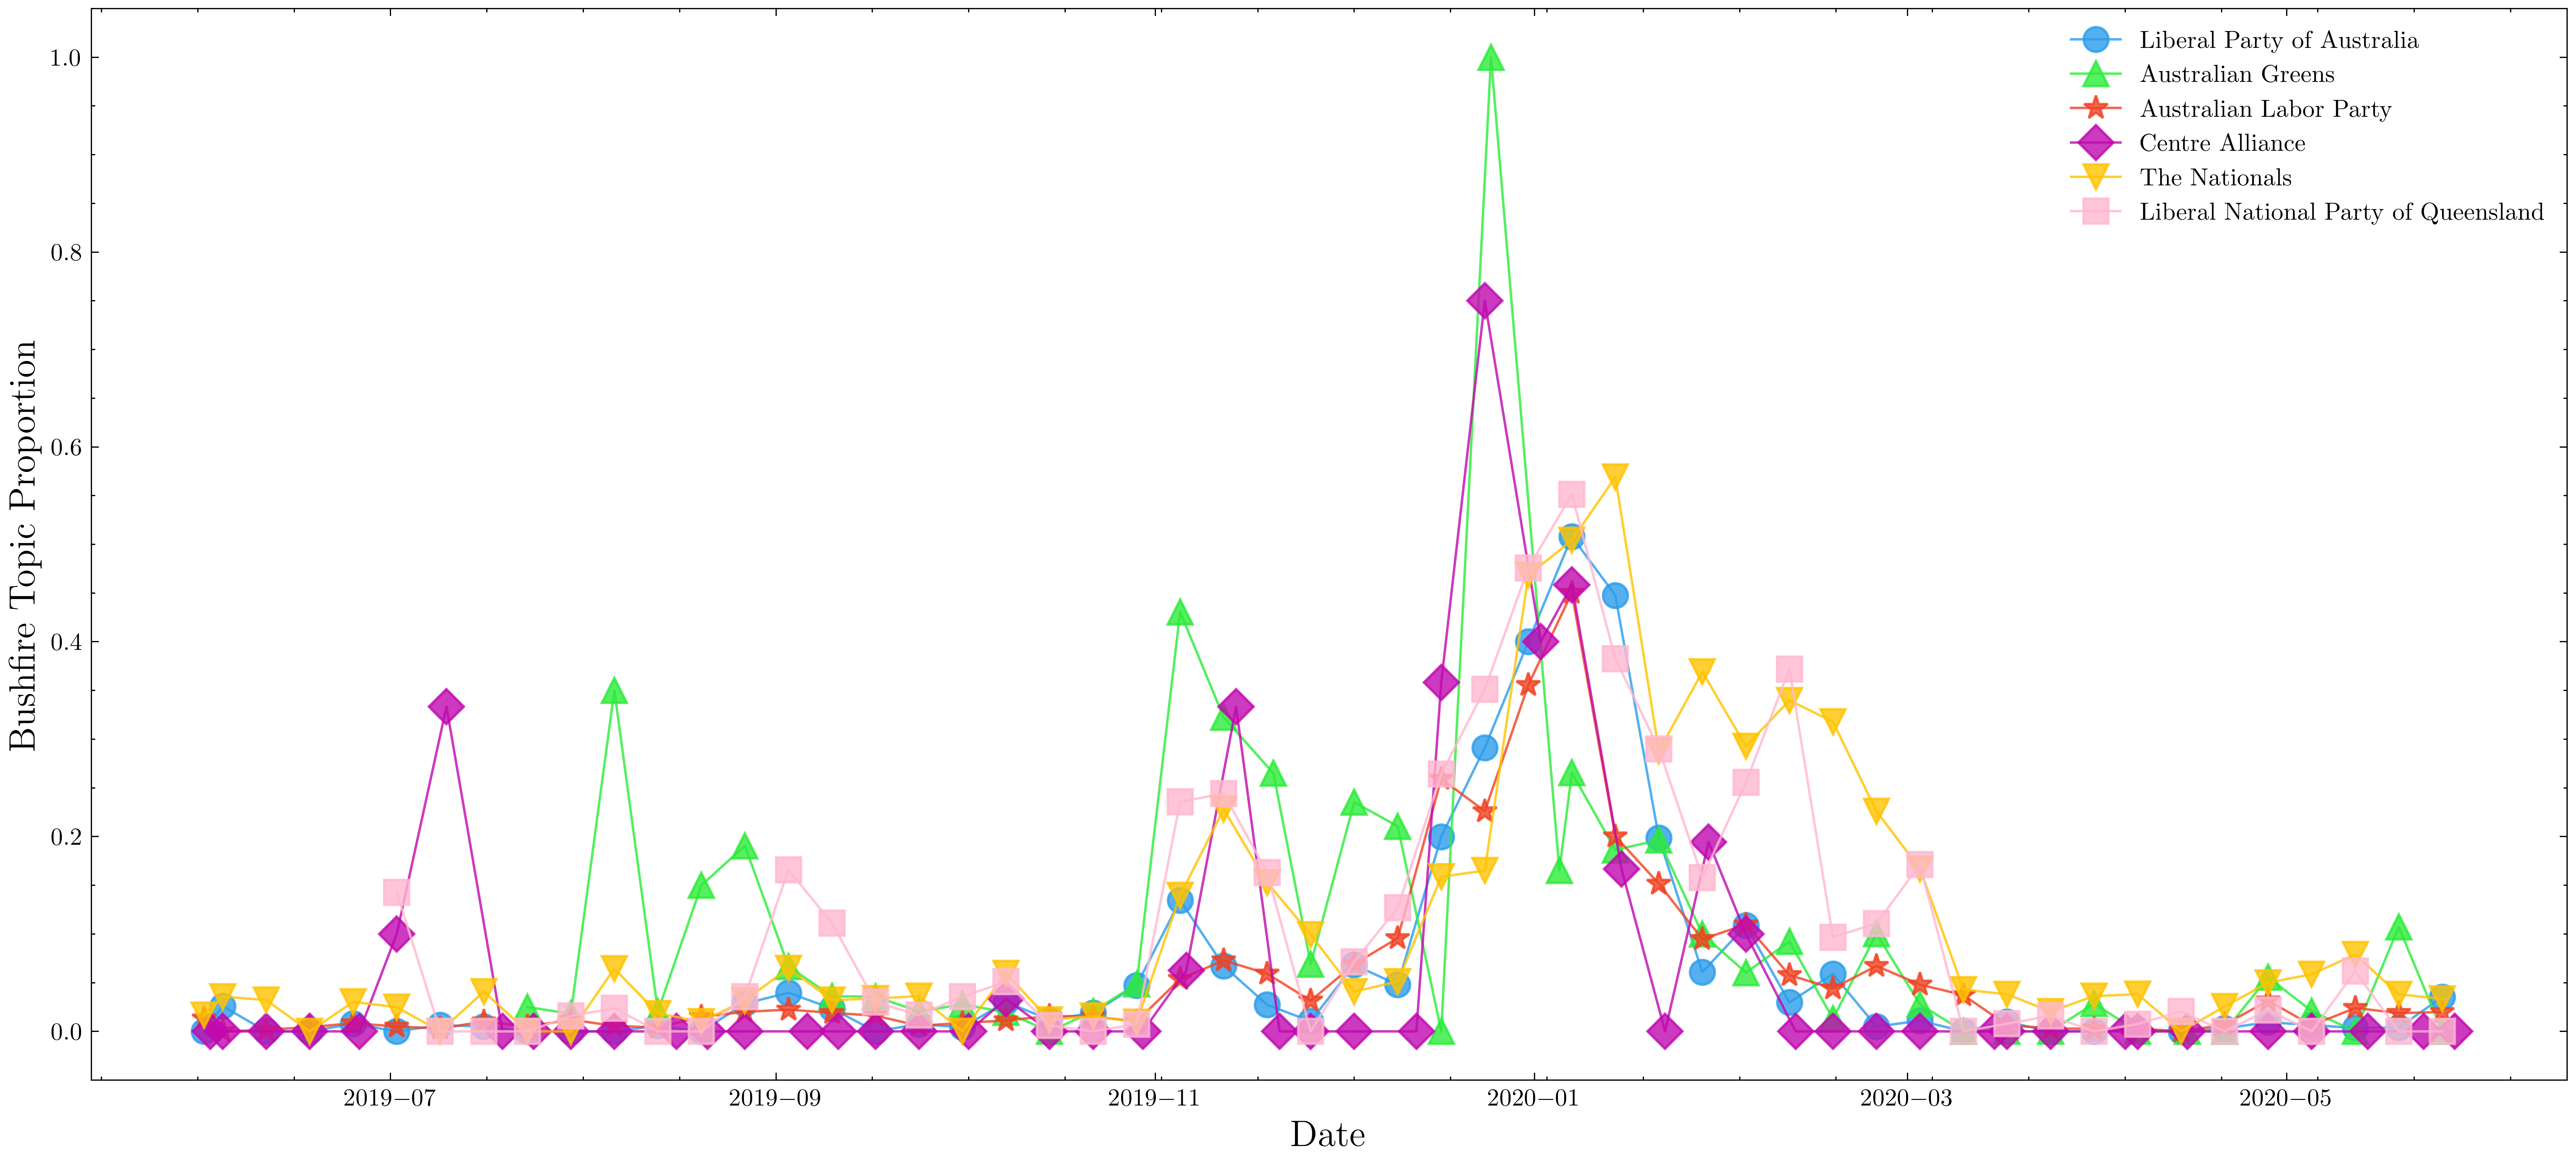

In [21]:
plot_topic(data, "bushfire_dummy", "bushfire_subset_plot.pdf")

In [22]:
#Display shape
print(topic_week.shape)
print(data.shape)

(359, 8)
(359, 3)


In [23]:
#Evaluate correlation between hSBM and manual subsetting
corrs = {}
parties = ['Australian Greens', 'Australian Labor Party', 'Centre Alliance',
           'Liberal National Party of Queensland', 
           'Liberal Party of Australia', 'The Nationals']

for party in parties:
    temp1 = topic_week.loc[topic_week["party"]==party]
    x = temp1["hsb_bushfire"].fillna(0).values
    temp2 = data.loc[data["party"]==party]
    y = temp2["bushfire_dummy"].fillna(0).values
    #Calculate within party correlation
    corrs[party] = stats.pearsonr(x,y)

corrs = pd.DataFrame(corrs).transpose()
corrs.columns = ["pearsons-r", "p-value"]
corrs.round(3)

pearsons-r  p-value
Australian Greens                          0.658      0.0
Australian Labor Party                     0.950      0.0
Centre Alliance                            0.704      0.0
Liberal National Party of Queensland       0.915      0.0
Liberal Party of Australia                 0.935      0.0
The Nationals                              0.918      0.0